# Pass Network (StatsBomb Data)

In [1]:
import math
import pandas as pd
from statsbombpy import sb
from mplsoccer import VerticalPitch

# First let's download our data
df = sb.events(match_id=3750235)

df[['x', 'y']] = df['location'].apply(pd.Series)
df[['end_x', 'end_y']] = df['pass_end_location'].apply(pd.Series)

df = df[df['team'] == 'Ajax']

In [2]:
#Retrieving Player Shirt Numbers

tactics = df[~df['tactics'].isnull()][['tactics', 'team']]

all_jersey_numbers = []
for y in tactics.to_dict(orient='records'):
    all_jersey_numbers.append(pd.DataFrame([{'player_id': x['player']['id'], 'jersey_number': x['jersey_number']} for x in y['tactics']['lineup']]))
    
jersey_numbers = pd.concat(all_jersey_numbers).drop_duplicates()

In [5]:
df.player.unique()

array([nan, 'Johan Cruyff', 'Piet Keizer', 'Arie Haan', 'Wim Suurbier',
       'Gerrie Mühren', 'Horst Blankenburg', 'Heinz Stuy', 'Sjaak Swart',
       'Ruud Krol', 'Johan Neeskens', 'Barry Hulshoff'], dtype=object)

In [7]:
# Make a new, single column for time and sort the events in chronological order
df["newsecond"] = 60 * df["minute"] + df["second"]

df.sort_values(by=['newsecond'])

# identify the passer and then the recipient, who'll be the playerId of the next action
df['passer'] = df['player_id']

df['recipient'] = df['passer'].shift(-1)

# filter for only passes and then successful passes
passes_df = df.loc[(df['type']=="Pass")]
passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")

completions = passes_df.loc[(passes_df['pass_outcome'] == "Successful")]

#find time of the team's first substitution and filter the df to only passes before that
#sub_df = df.loc[(df['type'] == "Substitution")]
#sub_df = df.loc[df['substitution_replacement'].isna() == True]
#first_sub = sub_df["newsecond"].min()

#if first_sub <= (60 * 45):
    #first_sub = 60 * 45

#completions = completions.loc[completions['newsecond'] < first_sub]

# Find Average Locations
average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean','count']})
average_locs_and_count.columns = ['x', 'y', 'count']

# find number of passes along each 'path' of passer to recipient
passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(
    average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
)

# set minimum threshold for pass arrows to be plotted. So this will only plot combos which occured at least 5 times.
passes_between = passes_between.loc[(passes_between['pass_count'] >= 4)]

/var/folders/dv/7l2p8f4j2gbcl552tflf3zw40000gn/T/ipykernel_31814/1408255225.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")


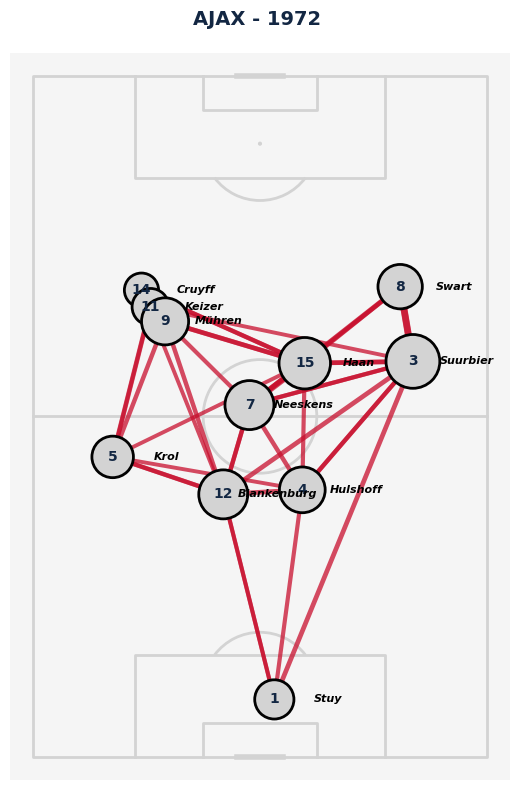

In [9]:
import math
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

# Improved pass line plotting function with a smoother arrow design
def pass_line_template(ax, x, y, end_x, end_y, line_color, alpha=0.8, width=3):
    ax.annotate(
        '',
        xy=(end_y, end_x),  # Correctly placed endpoint
        xytext=(y, x),      # Correctly placed start point
        zorder=1,
        arrowprops=dict(
            arrowstyle='-|>',
            linewidth=width,
            color=line_color,
            alpha=alpha,
            shrinkA=0,  # Ensures arrows fit better
            shrinkB=0
        )
    )

# Function to shrink the arrow based on distance
def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2, width=3, alpha=0.8):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y - y, end_x - x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color, alpha=alpha, width=width)

# Create pitch and figure
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#f5f5f5', line_color='#d3d3d3', line_zorder=1)
fig, ax = pitch.draw(figsize=(12, 8))

# Plot arrows for passes
for index, row in passes_between.iterrows():
    pass_line_template_shrink(
        ax,
        row['x'], row['y'],
        row['x_end'], row['y_end'],
        line_color='#c8102E',  # Improved to a vibrant red  #D2122E  
        width=2 + row['pass_count'] / passes_between['pass_count'].max() * 3,  # Dynamic width based on pass count
        alpha=0.75
    )

# Improved node plotting
node_sizes = average_locs_and_count['count'] / average_locs_and_count['count'].max() * 1500  # Scaled size
pitch.scatter(
    average_locs_and_count.x,
    average_locs_and_count.y,
    s=node_sizes,
    color='#d3d3d3',  # Neutral node color
    edgecolors="#010101",  # Strong contrast for edges
    linewidth=2,
    alpha=1,
    ax=ax,
    zorder=2
)

# Annotating nodes with jersey numbers and player names
for index, row in average_locs_and_count.iterrows():
    # Get the player's jersey number and name
    jersey_no = jersey_numbers[jersey_numbers['player_id'] == row.name]['jersey_number'].values[0]
    player_name = df[df['player_id'] == row.name]['player'].values[0]
    last_name = player_name.split()[-1]  # Extract the last name

    # Annotate the jersey number
    pitch.annotate(
        jersey_no,
        xy=(row.x, row.y),
        c='#132743',  # Dark text for visibility
        va='center',
        ha='center',
        size=10,
        fontweight='bold',
        ax=ax
    )

    # Annotate the player's name slightly below the node
    pitch.annotate(
        last_name,
        xy=(row.x, row.y + 9.5),  # Slightly offset below the node
        c='black',
        va='center',
        ha='center',
        size=8,
        fontstyle='italic',
        weight='bold',
        ax=ax
    )

# Adding a title for the plot
ax.set_title(
    "AJAX - 1972 ",
    fontsize=14,
    fontweight='bold',
    color='#132743',
    pad=20
)

plt.tight_layout()
plt.show()


# Pass Networks in a Grid

/var/folders/dv/7l2p8f4j2gbcl552tflf3zw40000gn/T/ipykernel_31814/2394071184.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")
/var/folders/dv/7l2p8f4j2gbcl552tflf3zw40000gn/T/ipykernel_31814/2394071184.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")
/var/folders/dv/7l2p8f4j2gbcl552tflf3zw40000gn/T/ipykernel_31814/2394071184.py:57: SettingWithCopyWarnin

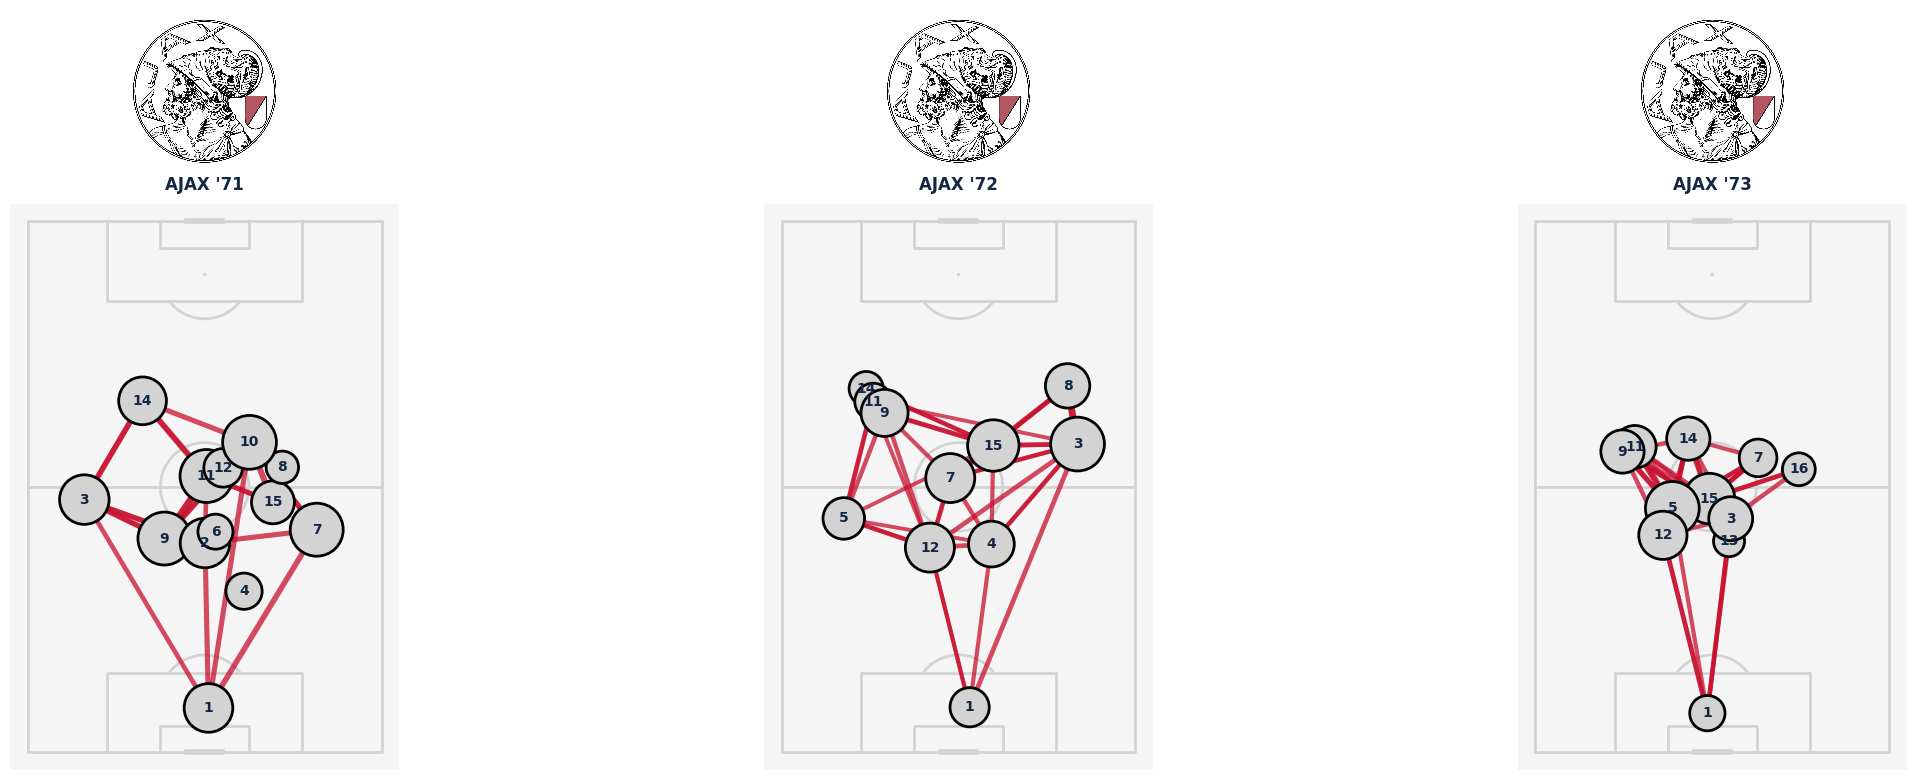

In [11]:
import math
import pandas as pd
from statsbombpy import sb
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Path to the Ajax logo (ensure the path is correct)
ajax_logo_path = '/Users/trymso/Desktop/ajax_logo.jpg' #download any picture to your working repository

# Match IDs and corresponding titles
match_ids = [3888711, 3750235, 3888706]
titles = ["AJAX '71", "AJAX '72", "AJAX '73"]  # Titles for each plot

# Function to add the logo above the plot
def add_logo(ax, logo_path, zoom=0.05):
    ax.add_artist(AnnotationBbox(OffsetImage(plt.imread(logo_path), zoom=zoom),
                                 (0.5, 1.2),  # Adjusted to place the logo slightly above the title
                                 xycoords='axes fraction', frameon=False))

# Create a figure with 3 subplots in a single row
fig, axs = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns for the grid

# Loop through each match ID and create a pass network
for i, match_id in enumerate(match_ids):
    # Load data
    df = sb.events(match_id=match_id)

    df[['x', 'y']] = df['location'].apply(pd.Series)
    df[['end_x', 'end_y']] = df['pass_end_location'].apply(pd.Series)

    df = df[df['team'] == 'Ajax']

    # Retrieving Player Shirt Numbers
    tactics = df[~df['tactics'].isnull()][['tactics', 'team']]

    all_jersey_numbers = []
    for y in tactics.to_dict(orient='records'):
        all_jersey_numbers.append(pd.DataFrame(
            [{'player_id': x['player']['id'], 'jersey_number': x['jersey_number']} for x in y['tactics']['lineup']]
        ))

    jersey_numbers = pd.concat(all_jersey_numbers).drop_duplicates()

    # Make a new, single column for time and sort the events in chronological order
    df["newsecond"] = 60 * df["minute"] + df["second"]

    df.sort_values(by=['newsecond'])

    # identify the passer and then the recipient, who'll be the playerId of the next action
    df['passer'] = df['player_id']

    df['recipient'] = df['passer'].shift(-1)

    # filter for only passes and then successful passes
    passes_df = df.loc[(df['type'] == "Pass")]
    passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")

    completions = passes_df.loc[(passes_df['pass_outcome'] == "Successful")]

    # Find Average Locations
    average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean', 'count']})
    average_locs_and_count.columns = ['x', 'y', 'count']

    # find number of passes along each 'path' of passer to recipient
    passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
    passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
    passes_between = passes_between.merge(
        average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
    )

    # set minimum threshold for pass arrows to be plotted. So this will only plot combos which occured at least 5 times.
    passes_between = passes_between.loc[(passes_between['pass_count'] >= 4)]

    # Improved pass line plotting function with a smoother arrow design
    def pass_line_template(ax, x, y, end_x, end_y, line_color, alpha=0.8, width=3):
        ax.annotate(
            '',
            xy=(end_y, end_x),  # Correctly placed endpoint
            xytext=(y, x),      # Correctly placed start point
            zorder=1,
            arrowprops=dict(
                arrowstyle='-|>',
                linewidth=width,
                color=line_color,
                alpha=alpha,
                shrinkA=0,  # Ensures arrows fit better
                shrinkB=0
            )
        )

    # Function to shrink the arrow based on distance
    def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2, width=3, alpha=0.8):
        dist = math.hypot(end_x - x, end_y - y)
        angle = math.atan2(end_y - y, end_x - x)
        upd_x = x + (dist - dist_delta) * math.cos(angle)
        upd_y = y + (dist - dist_delta) * math.sin(angle)
        pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color, alpha=alpha, width=width)

    # Create pitch for the current subplot
    pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#f5f5f5', line_color='#d3d3d3', line_zorder=1)
    pitch.draw(ax=axs[i])

    # Plot arrows for passes
    for index, row in passes_between.iterrows():
        pass_line_template_shrink(
            axs[i],
            row['x'], row['y'],
            row['x_end'], row['y_end'],
            line_color='#c8102E',  # Improved to a vibrant red
            width=2 + row['pass_count'] / passes_between['pass_count'].max() * 3,  # Dynamic width based on pass count
            alpha=0.75
        )

    # Improved node plotting
    node_sizes = average_locs_and_count['count'] / average_locs_and_count['count'].max() * 1500  # Scaled size
    pitch.scatter(
        average_locs_and_count.x,
        average_locs_and_count.y,
        s=node_sizes,
        color='#d3d3d3',  # Neutral node color
        edgecolors="#010101",  # Strong contrast for edges
        linewidth=2,
        alpha=1,
        ax=axs[i],
        zorder=2
    )

    # Annotating nodes with jersey numbers and player names
    for index, row in average_locs_and_count.iterrows():
        # Get the player's jersey number and name
        jersey_no = jersey_numbers[jersey_numbers['player_id'] == row.name]['jersey_number'].values[0]
        player_name = df[df['player_id'] == row.name]['player'].values[0]
        last_name = player_name.split()[-1]  # Extract the last name

        # Annotate the jersey number
        pitch.annotate(
            jersey_no,
            xy=(row.x, row.y),
            c='#132743',  # Dark text for visibility
            va='center',
            ha='center',
            size=10,
            fontweight='bold',
            ax=axs[i]
        )

        # Annotate the player's name slightly below the node
        #pitch.annotate(
            #last_name,
            #xy=(row.x, row.y + 9.5),  # Slightly offset below the node
            #c='grey',
            #va='center',
            #ha='center',
            #size=7,
            #fontstyle='italic',
            #weight='bold',
            #ax=axs[i]
        #)

    # Adding the custom title
    axs[i].set_title(
        titles[i],  # Custom title
        fontsize=12,  # Slightly smaller font size for better alignment
        fontweight='bold',
        color='#132743',
        pad=10  # Increase padding to avoid overlap with the logo
    )

    # Adding the Ajax logo
    add_logo(axs[i], ajax_logo_path)

plt.tight_layout()
plt.show()


In [263]:
fig.savefig('/Users/Trymso/Desktop/Ajax1.png', dpi=300, bbox_inches='tight')

# Player Pass Connections for Johan Cruyff

In [13]:
import math
import pandas as pd
from statsbombpy import sb
from mplsoccer import VerticalPitch

df = sb.events(match_id=3750235)

df[['x', 'y']] = df['location'].apply(pd.Series)
df[['end_x', 'end_y']] = df['pass_end_location'].apply(pd.Series)

df = df[df['team'] == 'Ajax']

In [14]:
#Retrieving Player Shirt Numbers

tactics = df[~df['tactics'].isnull()][['tactics', 'team']]

all_jersey_numbers = []
for y in tactics.to_dict(orient='records'):
    all_jersey_numbers.append(pd.DataFrame([{'player_id': x['player']['id'], 'jersey_number': x['jersey_number']} for x in y['tactics']['lineup']]))
    
jersey_numbers = pd.concat(all_jersey_numbers).drop_duplicates()

In [17]:
# Drop duplicates based on 'player' and 'player_id' and sort the data
unique_players = df[['player', 'player_id']].drop_duplicates().sort_values(by=['player', 'player_id'])

# Display the sorted unique players
display(unique_players)


,player,player_id
8,Arie Haan,39719.0
48,Barry Hulshoff,39726.0
11,Gerrie Mühren,39724.0
23,Heinz Stuy,39728.0
19,Horst Blankenburg,39729.0
6,Johan Cruyff,39713.0
44,Johan Neeskens,39721.0
7,Piet Keizer,39716.0
33,Ruud Krol,39720.0
31,Sjaak Swart,39723.0


/var/folders/dv/7l2p8f4j2gbcl552tflf3zw40000gn/T/ipykernel_31814/714606190.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")


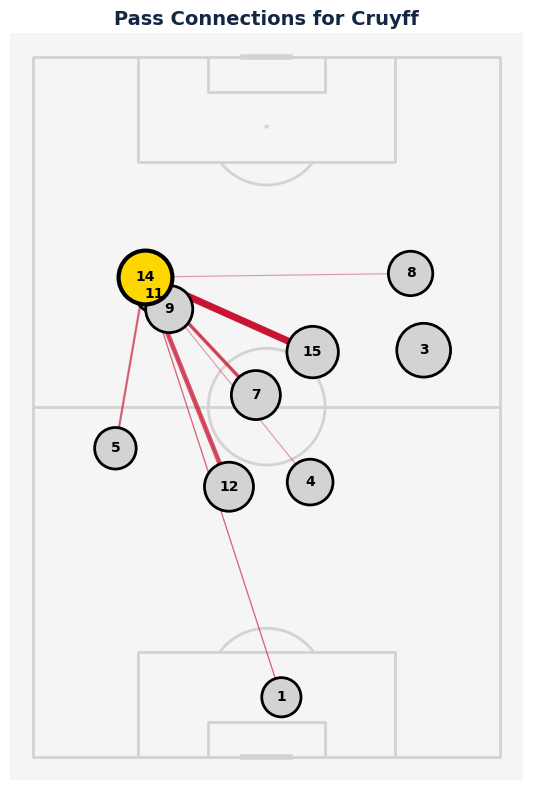

In [19]:
import math
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

# Johan Cruyff's player ID (make sure this is correct)
cruyff_id = 39713  # Set as the player ID directly, not a DataFrame

# Identify the passer and recipient for passes
df['passer'] = df['player_id']
df['recipient'] = df['passer'].shift(-1)  # The recipient is the next player's ID in sequence

# Filter for only passes and fill missing pass outcomes as "Successful"
passes_df = df.loc[(df['type'] == "Pass")]
passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")

# Filter for only successful passes
completions = passes_df.loc[passes_df['pass_outcome'] == "Successful"]

# Find Average Locations
average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean','count']})
average_locs_and_count.columns = ['x', 'y', 'count']

# Filter for passes involving Johan Cruyff
cruyff_completions = completions[
    (completions['passer'] == cruyff_id) | (completions['recipient'] == cruyff_id)
]


# Group by passer and recipient to calculate pass counts
cruyff_passes_between = cruyff_completions.groupby(['passer', 'recipient']).id.count().reset_index()
cruyff_passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

# Merge with average locations for plotting
cruyff_passes_between = cruyff_passes_between.merge(
    average_locs_and_count, left_on='passer', right_index=True
)
cruyff_passes_between = cruyff_passes_between.merge(
    average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
)

# Drawing the pitch
fig, ax = plt.subplots(figsize=(12, 8))
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#f5f5f5', line_color='#d3d3d3', line_zorder=1)
pitch.draw(ax=ax)

# Highlight Johan Cruyff with a distinct color
target_node_color = '#FFD700'  # Gold for Johan Cruyff's node
connection_color_base = '#c8102E'  # Red for connections
team_color = '#d3d3d3'  # Grey for other nodes

# Normalize pass counts for line width and color intensity
max_pass_count = cruyff_passes_between['pass_count'].max()

# Plot connections involving Johan Cruyff
for index, row in cruyff_passes_between.iterrows():
    width = row['pass_count'] / max_pass_count * 6  # Dynamic line width
    alpha = 0.3 + (row['pass_count'] / max_pass_count * 0.7)  # Dynamic alpha for color intensity
    
    ax.annotate(
        '',
        xy=(row['y_end'], row['x_end']),
        xytext=(row['y'], row['x']),
        arrowprops=dict(
            arrowstyle='-|>',
            color=connection_color_base,
            lw=width,
            alpha=alpha,  # Adjust alpha for intensity
        ),
        zorder=1,
    )

# Plot nodes for all connected players
node_sizes = average_locs_and_count['count'] / average_locs_and_count['count'].max() * 1500
pitch.scatter(
    average_locs_and_count.x,
    average_locs_and_count.y,
    s=node_sizes,
    c=team_color,
    edgecolors="black",
    linewidth=2,
    ax=ax
)

# Highlight Johan Cruyff's node
cruyff_location = average_locs_and_count.loc[cruyff_id]
pitch.scatter(
    cruyff_location.x,
    cruyff_location.y,
    s=1500,
    c=target_node_color,
    edgecolors="black",
    linewidth=3,
    ax=ax,
    zorder=3,
)

# Annotating shirt numbers
for index, row in average_locs_and_count.iterrows():
    jersey_no = jersey_numbers[jersey_numbers['player_id'] == row.name]['jersey_number'].values[0]
    pitch.annotate(
        jersey_no,
        xy=(row.x, row.y),
        c='black',
        va='center',
        ha='center',
        size=10,
        fontweight='bold',
        ax=ax,
    )

# Retrieve the player's name
player_full_name = df[df['player_id'] == cruyff_id]['player'].values[0]
player_last_name = player_full_name.split()[-1]  # Extract the last name

# Title for the pass network
ax.set_title(
    f'Pass Connections for {player_last_name}',
    fontsize=14,
    fontweight='bold',
    c='#132743',
)

plt.tight_layout()
plt.show()


In [21]:
fig.savefig('/Users/Trymso/Desktop/Cruyff_connections2.png', dpi=300, bbox_inches='tight')

# Player Pass Connections Grid

/var/folders/dv/7l2p8f4j2gbcl552tflf3zw40000gn/T/ipykernel_8546/44264452.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")
/var/folders/dv/7l2p8f4j2gbcl552tflf3zw40000gn/T/ipykernel_8546/44264452.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")
/var/folders/dv/7l2p8f4j2gbcl552tflf3zw40000gn/T/ipykernel_8546/44264452.py:42: SettingWithCopyWarning: 
A val

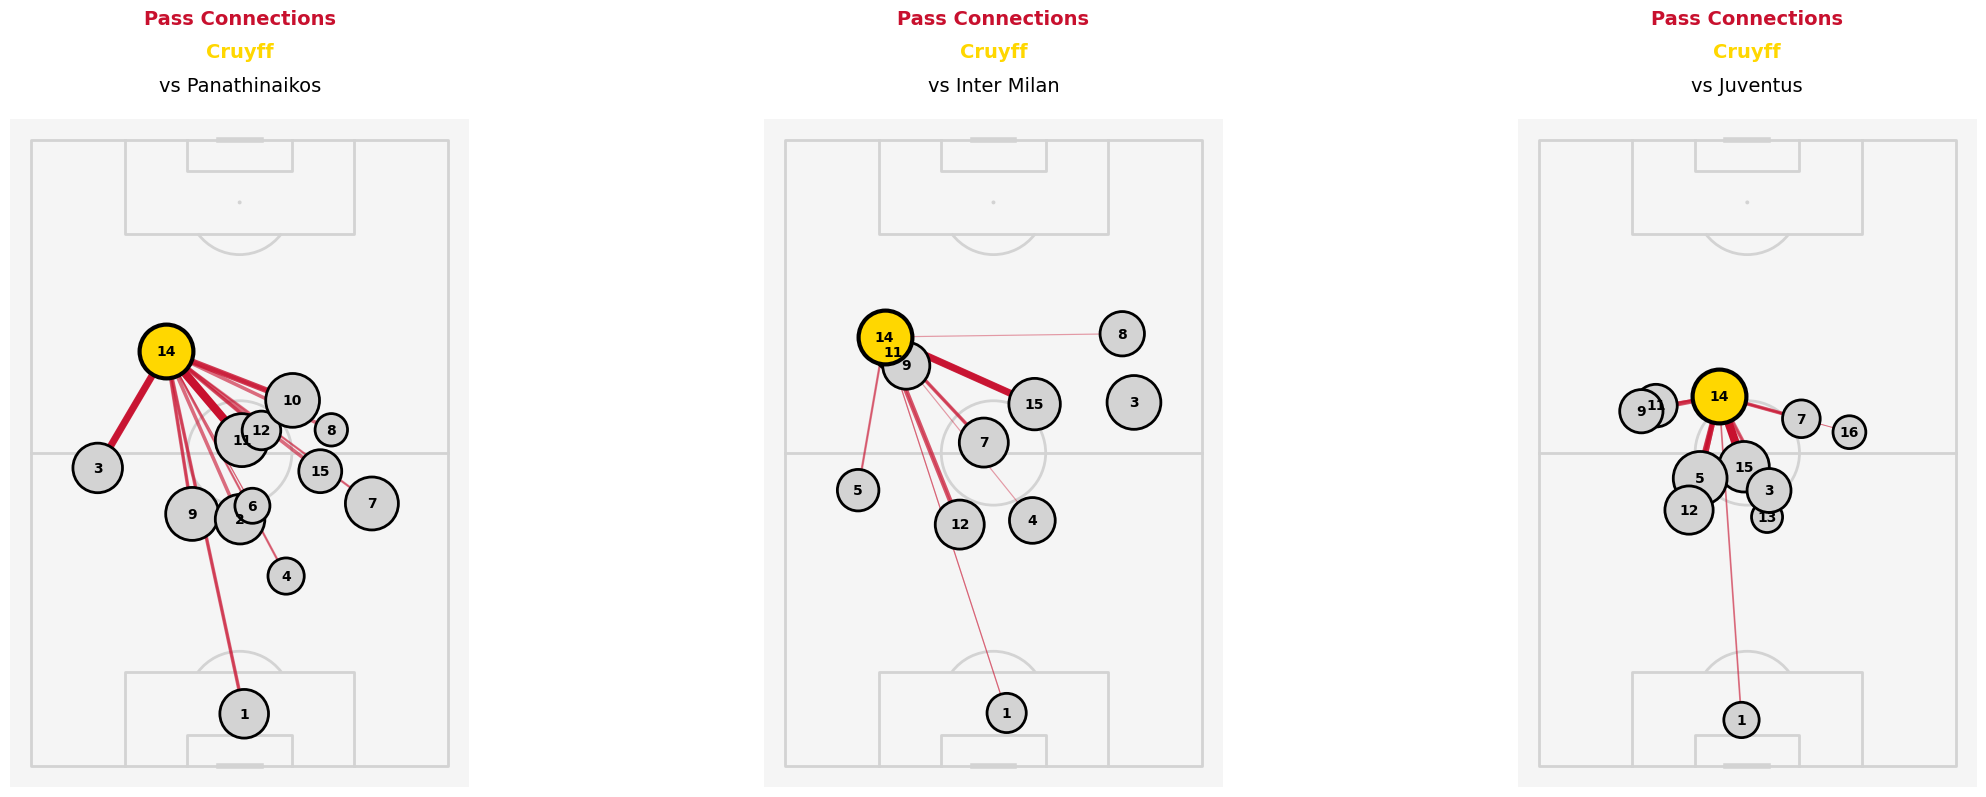

In [64]:
import math
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

# Match IDs and Johan Cruyff's player ID
match_ids = [3888711, 3750235, 3888706]
cruyff_id = 39713  # Johan Cruyff's player ID

# Create a figure with 3 subplots in a single row
fig, axs = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns for the grid

# Loop through each match ID
for i, match_id in enumerate(match_ids):
    # Load match events data
    df = sb.events(match_id=match_id)

    df[['x', 'y']] = df['location'].apply(pd.Series)
    df[['end_x', 'end_y']] = df['pass_end_location'].apply(pd.Series)

    away_team = df[df['team'] != 'Ajax']['team'].unique()[0]
    
    df = df[df['team'] == 'Ajax']
    

     # Retrieving Player Shirt Numbers
    tactics = df[~df['tactics'].isnull()][['tactics', 'team']]

    all_jersey_numbers = []
    for y in tactics.to_dict(orient='records'):
        all_jersey_numbers.append(pd.DataFrame(
            [{'player_id': x['player']['id'], 'jersey_number': x['jersey_number']} for x in y['tactics']['lineup']]
        ))

    jersey_numbers = pd.concat(all_jersey_numbers).drop_duplicates()

    # Identify the passer and recipient for passes
    df['passer'] = df['player_id']
    df['recipient'] = df['passer'].shift(-1)  # The recipient is the next player's ID in sequence

    # Filter for only passes and fill missing pass outcomes as "Successful"
    passes_df = df.loc[(df['type'] == "Pass")]
    passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")

    # Filter for only successful passes
    completions = passes_df.loc[passes_df['pass_outcome'] == "Successful"]

    # Find Average Locations
    average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean', 'count']})
    average_locs_and_count.columns = ['x', 'y', 'count']

    # Filter for passes involving Johan Cruyff
    cruyff_completions = completions[
        (completions['passer'] == cruyff_id) | (completions['recipient'] == cruyff_id)
    ]

    # Group by passer and recipient to calculate pass counts
    cruyff_passes_between = cruyff_completions.groupby(['passer', 'recipient']).id.count().reset_index()
    cruyff_passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # Merge with average locations for plotting
    cruyff_passes_between = cruyff_passes_between.merge(
        average_locs_and_count, left_on='passer', right_index=True
    )
    cruyff_passes_between = cruyff_passes_between.merge(
        average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
    )

    # Drawing the pitch
    pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#f5f5f5', line_color='#d3d3d3', line_zorder=1)
    pitch.draw(ax=axs[i])

    # Highlight Johan Cruyff with a distinct color
    target_node_color = '#FFD700'  # Gold for Johan Cruyff's node
    connection_color_base = '#c8102E'  # Red for connections
    team_color = '#d3d3d3'  # Grey for other nodes

    # Normalize pass counts for line width and color intensity
    max_pass_count = cruyff_passes_between['pass_count'].max()

    # Plot connections involving Johan Cruyff
    for index, row in cruyff_passes_between.iterrows():
        width = row['pass_count'] / max_pass_count * 6  # Dynamic line width
        alpha = 0.3 + (row['pass_count'] / max_pass_count * 0.7)  # Dynamic alpha for color intensity

        axs[i].annotate(
            '',
            xy=(row['y_end'], row['x_end']),
            xytext=(row['y'], row['x']),
            arrowprops=dict(
                arrowstyle='-|>',
                color=connection_color_base,
                lw=width,
                alpha=alpha,  # Adjust alpha for intensity
            ),
            zorder=1,
        )

    # Plot nodes for all connected players
    node_sizes = average_locs_and_count['count'] / average_locs_and_count['count'].max() * 1500
    pitch.scatter(
        average_locs_and_count.x,
        average_locs_and_count.y,
        s=node_sizes,
        c=team_color,
        edgecolors="black",
        linewidth=2,
        ax=axs[i]
    )

    # Highlight Johan Cruyff's node
    cruyff_location = average_locs_and_count.loc[cruyff_id]
    pitch.scatter(
        cruyff_location.x,
        cruyff_location.y,
        s=1500,
        c=target_node_color,
        edgecolors="black",
        linewidth=3,
        ax=axs[i],
        zorder=3,
    )

    # Annotating shirt numbers
    for index, row in average_locs_and_count.iterrows():
        jersey_no = jersey_numbers[jersey_numbers['player_id'] == row.name]['jersey_number'].values[0]
        pitch.annotate(
            jersey_no,
            xy=(row.x, row.y),
            c='black',
            va='center',
            ha='center',
            size=10,
            fontweight='bold',
            ax=axs[i],
        )

    # Retrieve the player's name
    player_full_name = df[df['player_id'] == cruyff_id]['player'].values[0]
    player_last_name = player_full_name.split()[-1]  # Extract the last name



    # Set colored and styled title
    #axs[i].set_title(
        #f"Pass Connections - {player_last_name} vs {away_team}",
        #fontsize=14,
        #pad=20,
        #color="black",
    #)


    
       # Add "Pass Connections" in red
    axs[i].text(
        0.5, 1.15,  # Coordinates for placement (centered above the plot)
        "Pass Connections",
        fontsize=14,
        color="#c8102E",  # Red color
        ha='center', va='center', transform=axs[i].transAxes,
        fontweight='bold'
    )
    
    # Add "Cruyff" in gold
    axs[i].text(
        0.5, 1.10,  # Slightly below the previous line
        f"{player_last_name}",
        fontsize=14,
        color="#FFD700",  # Gold color
        ha='center', va='center', transform=axs[i].transAxes,
        fontweight='bold'
    )
    
    # Add "vs {away_team}" in default black
    axs[i].text(
        0.5, 1.05,  # Further below the previous line
        f"vs {away_team}",
        fontsize=14,
        color="black",
        ha='center', va='center', transform=axs[i].transAxes,
    )



plt.tight_layout()
plt.show()


In [66]:
fig.savefig('/Users/Trymso/Desktop/Cruyff_connections.png', dpi=300, bbox_inches='tight')

# xG Flow Chart

In [2]:
import math
import pandas as pd
from statsbombpy import sb
from mplsoccer import VerticalPitch

# First let's download our data
df = sb.events(match_id=3750235)

In [4]:
df.columns

Index(['50_50', 'bad_behaviour_card', 'ball_receipt_outcome',
       'ball_recovery_recovery_failure', 'block_deflection', 'block_offensive',
       'carry_end_location', 'clearance_aerial_won', 'clearance_body_part',
       'clearance_head', 'clearance_left_foot', 'clearance_right_foot',
       'counterpress', 'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun',
       'duel_outcome', 'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive',
       'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive',
       'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome',
       'goalkeeper_position', 'goalkeeper_punched_out', 'goalkeeper_technique',
       'goalkeeper_type', 'half_end_early_video_end', 'id', 'index',
       'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_

In [6]:
df.type.unique()

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Miscontrol', 'Pressure', 'Ball Recovery', 'Interception', 'Shot',
       'Goal Keeper', 'Duel', 'Dribble', 'Dribbled Past', 'Clearance',
       'Dispossessed', 'Block', 'Foul Committed', 'Foul Won',
       'Injury Stoppage', 'Substitution', 'Referee Ball-Drop', '50/50',
       'Half End', 'Shield', 'Bad Behaviour'], dtype=object)

In [8]:
# And filter the columns we need
df = df[df['type'] == 'Shot']

df = df[['team', 'player', 'minute', 'period', 'shot_statsbomb_xg', 'shot_outcome']]
df.head()

,team,player,minute,period,shot_statsbomb_xg,shot_outcome
2554,Ajax,Wim Suurbier,1,1,0.017220,Off T
2555,Ajax,Arie Haan,3,1,0.026420,Blocked
2556,Ajax,Arie Haan,3,1,0.010277,Saved
2557,Ajax,Gerrie Mühren,10,1,0.029122,Off T
2558,Inter Milan,Sandro Mazzola,12,1,0.012022,Off T


In [10]:
# Now let's create a column for the cumulative xG for each team
df['cumulative_xG'] = df.groupby('team')['shot_statsbomb_xg'].cumsum()

In [18]:
df.head()

,team,player,minute,period,shot_statsbomb_xg,shot_outcome,cumulative_xG
2554,Ajax,Wim Suurbier,1,1,0.017220,Off T,0.017220
2555,Ajax,Arie Haan,3,1,0.026420,Blocked,0.043640
2556,Ajax,Arie Haan,3,1,0.010277,Saved,0.053917
2557,Ajax,Gerrie Mühren,10,1,0.029122,Off T,0.083039
2558,Inter Milan,Sandro Mazzola,12,1,0.012022,Off T,0.012022


Text(0.1, 0.0, '@mckayjohns/twitter')

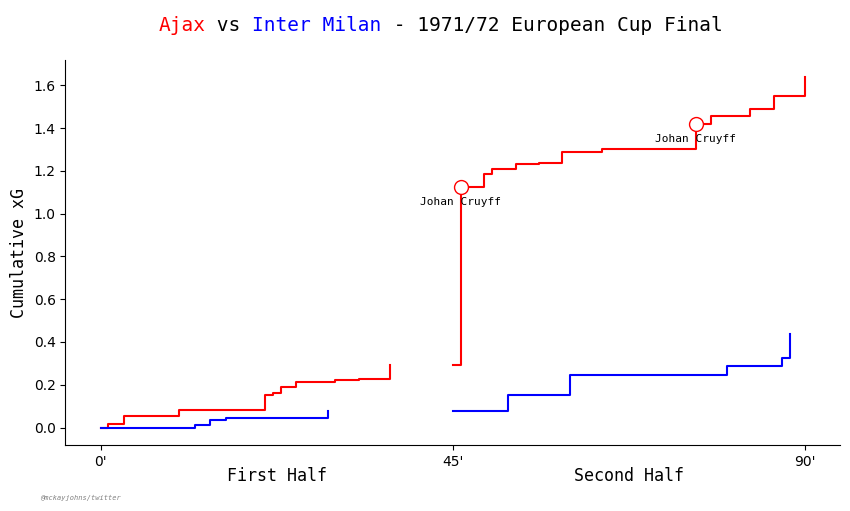

In [30]:
# We now have the data we need to create the flow chart
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

# Plot the xG for each team by half
# We want to make it so the lines both start at 0

liverpool_color = 'red'
real_madrid_color = 'blue'

for team in df['team'].unique():
    
    team_df = df[df['team'] == team]
    
    # add a 0 xG row at the start of the match
    team_df = pd.concat([pd.DataFrame({'team': team, 'minute': 0, 'shot_statsbomb_xg': 0, 'shot_outcome': 'Goal', 'cumulative_xG': 0, 'period': 1}, index=[0]), team_df])
    
    # Also add a row at the beginning of the second half to make the lines start where the first half ended
    team_df = pd.concat([team_df[team_df['period'] == 1], pd.DataFrame({'team': team, 'minute': 45, 'shot_statsbomb_xg': 0, 'shot_outcome': 'Goal', 'cumulative_xG': team_df[team_df['period'] == 1]['cumulative_xG'].iloc[-1], 'period': 2}, index=[0]), team_df[team_df['period'] == 2]])

    for period in team_df['period'].unique():
        period_df = team_df[team_df['period'] == period]
        ax.plot(
            period_df['minute'], 
            period_df['cumulative_xG'], 
            label=team, 
            drawstyle='steps-post',
            c=liverpool_color if team == 'Ajax' else real_madrid_color
        )   
        

# We Can add a scatter plot to show the goals
for team in df['team'].unique():
    team_df = df[(df['team'] == team) & (df['shot_outcome'] == 'Goal')].to_dict(orient='records')
    for x in team_df:
        ax.scatter(
            x['minute'], 
            x['cumulative_xG'], 
            c='white',
            edgecolor=liverpool_color if team == 'Ajax' else real_madrid_color,
            s=100,
            # We want the goals to be on top of the lines
            zorder=5
        )
        
        # add a label to the goals for the player who scored
        ax.text(
            x['minute'], 
            x['cumulative_xG'] - .07, 
            x['player'], 
            ha='center', 
            va='center', 
            fontfamily='monospace', 
            fontsize=8,
            zorder=10
        )
        
# Let's label the x axis with first and second half
ax.set_xticks([0, 45, 90])
ax.set_xticklabels(['0\'', '45\'', '90\''])

# Lets add the actual words "First Half" and "Second Half" to the plot under the x axis
ax.text(22.5, -.25, 'First Half', ha='center', fontfamily='monospace', fontsize=12)
ax.text(67.5, -.25, 'Second Half', ha='center', fontfamily='monospace', fontsize=12)

# Let's label the y axis with the cumulative xG
ax.set_ylabel('Cumulative xG', fontfamily='monospace', fontsize=12)

# Let's get rid of the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Let's change the color of the title to show which team is which using the highlight-text package
from highlight_text import fig_text

fig_text(
    0.5,
    0.95,
    '<Ajax> vs <Inter Milan> - 1971/72 European Cup Final', 
    fontsize=14, 
    ha='center', 
    va='center', 
    ax=ax, 
    fontfamily='monospace', 
    highlight_textprops=[{'color': liverpool_color}, {'color': real_madrid_color}]
)


# Now let's add a twitter @ to the bottom left of the plot
fig.text(
    0.1, 
    0.00, 
    '@mckayjohns/twitter', 
    fontsize=5, 
    fontstyle='oblique', 
    fontfamily='monospace', 
    color='gray'
)

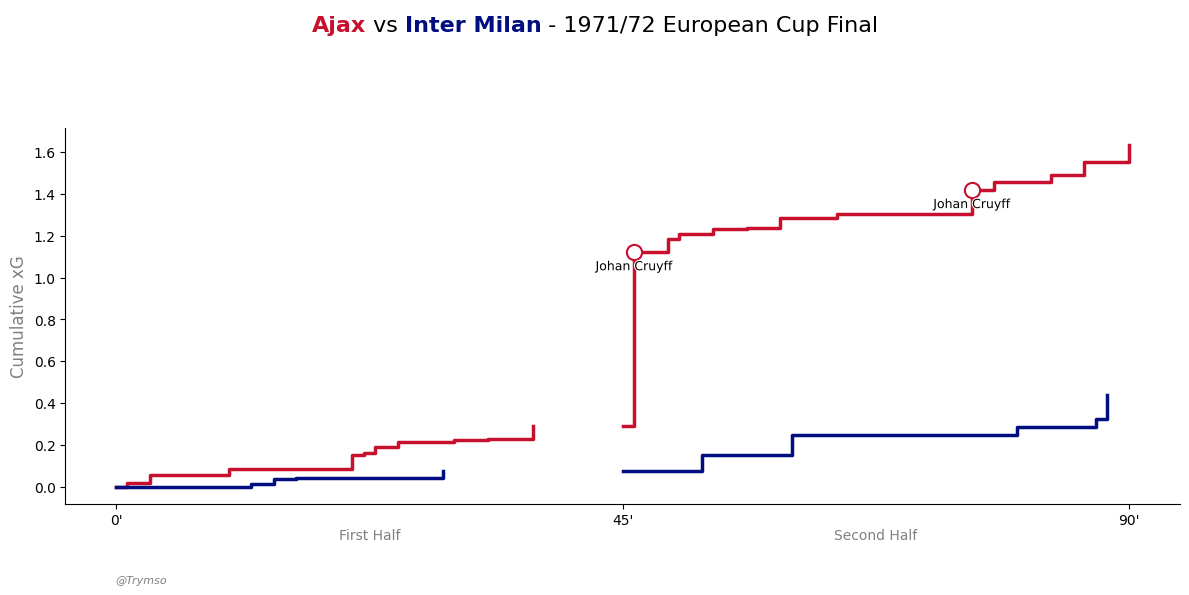

In [36]:
import matplotlib.pyplot as plt
from highlight_text import fig_text
import matplotlib.patheffects as path_effects

# Define team colors
ajax_color = '#c8102E'  # Bright red for Ajax
inter_color = '#010E80'  # Deep blue for Inter Milan

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))  # Slightly wider for better spacing

for team in df['team'].unique():
    team_df = df[df['team'] == team]
    
    # Add a 0 xG row at the start of the match
    team_df = pd.concat([pd.DataFrame({'team': team, 'minute': 0, 'shot_statsbomb_xg': 0, 'shot_outcome': 'Goal', 'cumulative_xG': 0, 'period': 1}, index=[0]), team_df])
    
    # Add a row at the beginning of the second half
    team_df = pd.concat([team_df[team_df['period'] == 1], pd.DataFrame({'team': team, 'minute': 45, 'shot_statsbomb_xg': 0, 'shot_outcome': 'Goal', 'cumulative_xG': team_df[team_df['period'] == 1]['cumulative_xG'].iloc[-1], 'period': 2}, index=[0]), team_df[team_df['period'] == 2]])

    # Plot lines for each team
    for period in team_df['period'].unique():
        period_df = team_df[team_df['period'] == period]
        ax.plot(
            period_df['minute'], 
            period_df['cumulative_xG'], 
            label=team, 
            drawstyle='steps-post',
            color=ajax_color if team == 'Ajax' else inter_color,
            linewidth=2.5
        )

# Highlight goals with scatter points
for team in df['team'].unique():
    team_df = df[(df['team'] == team) & (df['shot_outcome'] == 'Goal')].to_dict(orient='records')
    for x in team_df:
        ax.scatter(
            x['minute'], 
            x['cumulative_xG'], 
            color='white',
            edgecolor=ajax_color if team == 'Ajax' else inter_color,
            s=120,
            zorder=5,
            linewidth=1.5
        )
        
        # Add goal scorer names
        ax.text(
            x['minute'], 
            x['cumulative_xG'] - .07, 
            x['player'], 
            ha='center', 
            va='center', 
            fontfamily='DejaVu Sans',  # Updated font
            fontsize=9,
            zorder=10,
            color='black',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()]
        )

# Add labels for the x-axis
ax.set_xticks([0, 45, 90])
ax.set_xticklabels(['0\'', '45\'', '90\''], fontsize=10, fontfamily='DejaVu Sans')

# Add half labels
ax.text(22.5, -.25, 'First Half', ha='center', fontfamily='DejaVu Sans', fontsize=10, color='gray')
ax.text(67.5, -.25, 'Second Half', ha='center', fontfamily='DejaVu Sans', fontsize=10, color='gray')

# Add y-axis label
ax.set_ylabel('Cumulative xG', fontfamily='DejaVu Sans', fontsize=12, color='gray')

# Remove right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Remove background grid
ax.grid(False)

# Add title with team colors using highlight_text
fig_text(
    0.5,
    0.95,
    '<Ajax> vs <Inter Milan> - 1971/72 European Cup Final', 
    fontsize=16, 
    ha='center', 
    va='center', 
    ax=ax, 
    fontfamily='DejaVu Sans', 
    highlight_textprops=[
        {'color': ajax_color, 'weight': 'bold'}, 
        {'color': inter_color, 'weight': 'bold'}
    ]
)

# Add Twitter handle
fig.text(
    0.1, 
    0.02, 
    '@Trymso', 
    fontsize=8, 
    fontstyle='italic', 
    fontfamily='DejaVu Sans', 
    color='gray'
)

# Adjust layout for a cleaner look
plt.tight_layout(rect=[0, 0.05, 1, 0.9])
plt.show()


In [38]:
fig.savefig('/Users/Trymso/Desktop/Cruyff_xgflow.png', dpi=300, bbox_inches='tight')

# Plotting Offensive Actions

In [1]:
import math
import pandas as pd
from statsbombpy import sb
from mplsoccer import VerticalPitch

# First let's download our data
df = sb.events(match_id=3750235)

In [3]:
df.type.unique()

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Miscontrol', 'Pressure', 'Ball Recovery', 'Interception', 'Shot',
       'Goal Keeper', 'Duel', 'Dribble', 'Dribbled Past', 'Clearance',
       'Dispossessed', 'Block', 'Foul Committed', 'Foul Won',
       'Injury Stoppage', 'Substitution', 'Referee Ball-Drop', '50/50',
       'Half End', 'Shield', 'Bad Behaviour'], dtype=object)

In [5]:
df.player.unique()

array([nan, 'Johan Cruyff', 'Piet Keizer', 'Arie Haan', 'Wim Suurbier',
       'Gerrie Mühren', 'Mauro Bellugi', 'Jair da Costa',
       'Tarcisio Burgnich', 'Horst Blankenburg', 'Roberto Boninsegna',
       'Heinz Stuy', 'Sjaak Swart', 'Gabriele Oriali', 'Ruud Krol',
       'Johan Neeskens', 'Ivano Bordon', 'Mario Frustalupi',
       'Giacinto Facchetti', 'Barry Hulshoff', 'Mario Giubertoni',
       'Sandro Mazzola', 'Gianfranco Bedin', 'Mario Bertini',
       'Sergio Pellizzaro'], dtype=object)

In [7]:
#separate start and end locations from coordinates
df[['x', 'y']] = df['location'].apply(pd.Series)
df[['pass_end_x', 'pass_end_y']] = df['pass_end_location'].apply(pd.Series)
df[['carry_end_x', 'carry_end_y']] = df['carry_end_location'].apply(pd.Series)

# And filter the columns we need
# Filter the dataframe to include only rows where 'type' is Shot, Pass, or Carry
df = df[df['type'].isin(['Shot', 'Pass', 'Carry'])]

df = df[df['player'] == 'Johan Cruyff']

In [9]:
df.head()

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,...,team_id,timestamp,type,under_pressure,x,y,pass_end_x,pass_end_y,carry_end_x,carry_end_y
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,806,00:00:04.925,Pass,NaN,60.0,40.0,62.4,40.2,NaN,NaN
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,806,00:01:11.307,Pass,NaN,84.1,43.3,93.7,36.8,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,806,00:01:13.979,Pass,True,79.3,42.5,79.0,55.0,NaN,NaN
41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,806,00:03:20.660,Pass,NaN,93.4,7.4,95.3,24.2,NaN,NaN
51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,806,00:04:21.759,Pass,NaN,120.0,0.1,116.4,34.9,NaN,NaN


In [11]:
df.columns

Index(['50_50', 'bad_behaviour_card', 'ball_receipt_outcome',
       'ball_recovery_recovery_failure', 'block_deflection', 'block_offensive',
       'carry_end_location', 'clearance_aerial_won', 'clearance_body_part',
       'clearance_head', 'clearance_left_foot', 'clearance_right_foot',
       'counterpress', 'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun',
       'duel_outcome', 'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive',
       'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive',
       'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome',
       'goalkeeper_position', 'goalkeeper_punched_out', 'goalkeeper_technique',
       'goalkeeper_type', 'half_end_early_video_end', 'id', 'index',
       'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_

In [13]:
df = df[['team', 'player', 'player_id', 'minute', 'period', 'type', 'shot_statsbomb_xg', 'pass_outcome','shot_outcome',
        'x', 'y', 'pass_end_x', 'pass_end_y', 'carry_end_x', 'carry_end_y' ]]
df.head(10)

,team,player,player_id,minute,period,type,shot_statsbomb_xg,pass_outcome,shot_outcome,x,y,pass_end_x,pass_end_y,carry_end_x,carry_end_y
6,Ajax,Johan Cruyff,39713.0,0,1,Pass,NaN,NaN,NaN,60.0,40.0,62.4,40.2,NaN,NaN
24,Ajax,Johan Cruyff,39713.0,1,1,Pass,NaN,Incomplete,NaN,84.1,43.3,93.7,36.8,NaN,NaN
25,Ajax,Johan Cruyff,39713.0,1,1,Pass,NaN,NaN,NaN,79.3,42.5,79.0,55.0,NaN,NaN
41,Ajax,Johan Cruyff,39713.0,3,1,Pass,NaN,NaN,NaN,93.4,7.4,95.3,24.2,NaN,NaN
51,Ajax,Johan Cruyff,39713.0,4,1,Pass,NaN,Incomplete,NaN,120.0,0.1,116.4,34.9,NaN,NaN
52,Ajax,Johan Cruyff,39713.0,4,1,Pass,NaN,Incomplete,NaN,120.0,0.1,116.4,40.7,NaN,NaN
113,Ajax,Johan Cruyff,39713.0,10,1,Pass,NaN,NaN,NaN,99.0,19.8,91.4,43.3,NaN,NaN
199,Ajax,Johan Cruyff,39713.0,20,1,Pass,NaN,Incomplete,NaN,94.8,30.8,104.5,38.6,NaN,NaN
212,Ajax,Johan Cruyff,39713.0,21,1,Pass,NaN,Incomplete,NaN,108.3,38.4,111.4,30.3,NaN,NaN
241,Ajax,Johan Cruyff,39713.0,24,1,Pass,NaN,Incomplete,NaN,90.5,26.6,93.3,42.6,NaN,NaN


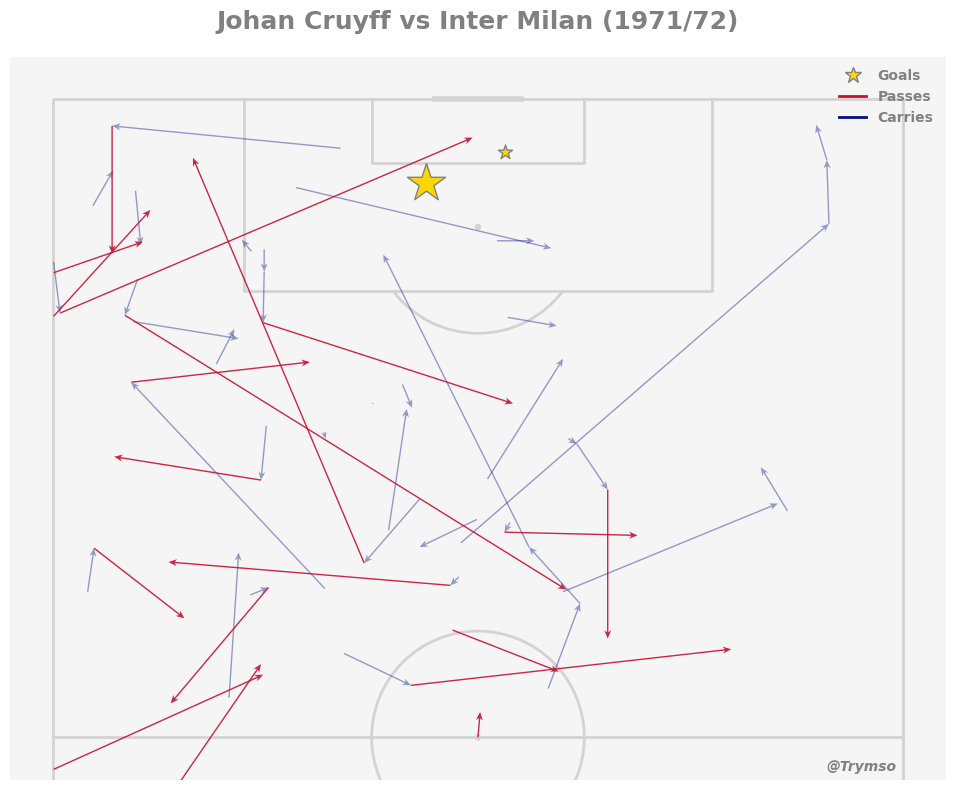

In [253]:
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

# Create the pitch
pitch = VerticalPitch(pitch_type='statsbomb', half=True, pitch_color='#f5f5f5', line_color='#d3d3d3', line_zorder=1)
fig, ax = pitch.draw(figsize=(12, 8))

# Filter the dataframe: successful passes, all carries, and all shots
df_filtered = df[
    (df['type'] == 'Shot') |
    ((df['type'] == 'Pass') & (df['pass_outcome'].isna())) |  # Only successful passes
    (df['type'] == 'Carry')  # Include all carries
]

# Loop through the dataframe and plot events based on their type
for _, row in df_filtered.iterrows():
    if row['type'] == 'Shot' and row['shot_outcome'] == 'Goal':
        # Plot goals with star markers
        pitch.scatter(
            x=row['x'], y=row['y'], 
            ax=ax, 
            s=1000 * (row['shot_statsbomb_xg'] if not pd.isna(row['shot_statsbomb_xg']) else 0.1), 
            color='gold', edgecolor='grey', zorder=3, marker='*'
        )
    elif row['type'] == 'Pass':
        # Plot successful passes as arrows
        if not pd.isna(row['pass_end_x']) and not pd.isna(row['pass_end_y']):
            pitch.arrows(
                xstart=row['x'], ystart=row['y'], 
                xend=row['pass_end_x'], yend=row['pass_end_y'], 
                ax=ax, color='#c8102E', width=1, headwidth=5, headlength=6, lw=2, alpha=0.9, zorder=2
            )


                
    elif row['type'] == 'Carry':
        # Plot carries as dashed arrows
        if not pd.isna(row['carry_end_x']) and not pd.isna(row['carry_end_y']):
            pitch.arrows(
                xstart=row['x'], ystart=row['y'], 
                xend=row['carry_end_x'], yend=row['carry_end_y'], 
                ax=ax, color='#010E80', width=1, headwidth=5, headlength=6, lw=2, 
                linestyle=(0, (5, 5)), alpha=0.4, zorder=1
            )


# Add a legend
legend_elements = [
    plt.Line2D([0], [0], color='gold', marker='*', label='Goals', markersize=12, linestyle='', markeredgecolor='grey'),
    plt.Line2D([0], [0], color='#c8102E', lw=2, label='Passes'),
    plt.Line2D([0], [0], color='#010E80', lw=2, label='Carries'),
]
legend = ax.legend(handles=legend_elements, loc='upper right', fontsize=10, frameon=False)

# Change the text color in the legend to grey
for text in legend.get_texts():
    text.set_color('grey')
    text.set_fontweight('bold')
    text.set_fontfamily('DejaVu Sans') 


# Add a title
ax.set_title("Johan Cruyff vs Inter Milan (1971/72)", fontsize=18, fontweight='bold', fontfamily='Dejavu Sans', color='grey', pad=20)

# Add Twitter handle
fig.text(
    0.79, 
    0.03, 
    '@Trymso', 
    fontsize=10, 
    fontstyle='italic',
    fontweight='bold',
    fontfamily='DejaVu Sans', 
    color='gray'
)

plt.show()


In [255]:
fig.savefig('/Users/Trymso/Desktop/Cruyff_actions.png', dpi=300, bbox_inches='tight')

In [ ]:
ajax_color = '#c8102E'  # Bright red for Ajax
inter_color = '#010E80'